In [3]:
using Plots, NLopt, DataFrames, CSV

directory = dirname(pwd())
subroutine_directory = joinpath(directory, "src", "SubRoutines_SCW")
output_directory = joinpath(directory, "Results", "SCW")
mkpath(output_directory)

include(joinpath(subroutine_directory, "AnimalWelfareModel.jl"))
include(joinpath(subroutine_directory, "helpers_SCWOptimization.jl"))
DICEFARM = create_AnimalWelfare()
run(DICEFARM)
println("Ran once")
BaseWelfare = DICEFARM[:welfare, :UTILITY]
MargCons 	= create_AnimalWelfare()
set_param!(MargCons, :neteconomy, :CEQ, 1e-9)  #dropping C by 1000 globally
run(MargCons)
MargConsWelfare = MargCons[:welfare, :UTILITY]
SCNumeraire 	= BaseWelfare - MargConsWelfare

SocialCosts = zeros(4) # Vegetarian; then each of 3 animal products

# ----- Need original amount consumed -------- #
OrigBeef = DICEFARM[:farm, :Beef]
OrigPork = DICEFARM[:farm, :Pork]
OrigPoultry = DICEFARM[:farm, :Poultry]

# ------ Add Vegetarian average pulse ------------------- #
BeefPulse = copy(OrigBeef)
PorkPulse = copy(OrigPork)
PoultryPulse = copy(OrigPoultry)

BeefPulse[6] = OrigBeef[6] + 1000*(4.8) 				
PorkPulse[6] = OrigPork[6]  + 1000*(2.7)
PoultryPulse[6] = OrigPoultry[6] + 1000*(6.7)

VegPulse = create_AnimalWelfare()
set_param!(VegPulse, :farm, :Beef, BeefPulse)
set_param!(VegPulse, :farm, :Poultry, PoultryPulse)
set_param!(VegPulse, :farm, :Pork, PorkPulse)

run(VegPulse)
VegWelfare = VegPulse[:welfare, :UTILITY]
SCCVeg     = (BaseWelfare - VegWelfare)/(SCNumeraire)

# ------- Loop Over Values of Cons Equiv ------------------------- #
SufferingEquiv = collect(.9:.1:2.8)
BenefitOfVegetarian = zeros(length(SufferingEquiv))
for (i,S) in enumerate(SufferingEquiv)
	tempM = create_AnimalWelfare()
	set_param!(tempM, :welfare, :CowEquiv, S)
	set_param!(tempM, :welfare, :ChickenEquiv, S)
	set_param!(tempM, :welfare, :PigEquiv, S)
	run(tempM)
	
	TempBaseWelfare = tempM[:welfare, :UTILITY]
	BeefPulse = copy(OrigBeef)
	PorkPulse = copy(OrigPork)
	PoultryPulse = copy(OrigPoultry)

	BeefPulse[6] = OrigBeef[6] + 1000*(4.8) 				#Add pulse to year 2020; pump up for Veg diets
	PorkPulse[6] = OrigPork[6]  + 1000*(2.7)
	PoultryPulse[6] = OrigPoultry[6] + 1000*(6.7)

	VegPulse = create_AnimalWelfare()
	set_param!(VegPulse, :welfare, :CowEquiv, S)
	set_param!(VegPulse, :welfare, :ChickenEquiv, S)
	set_param!(VegPulse, :welfare, :PigEquiv, S)
	set_param!(VegPulse, :farm, :Beef, BeefPulse)
	set_param!(VegPulse, :farm, :Poultry, PoultryPulse)
	set_param!(VegPulse, :farm, :Pork, PorkPulse)
	run(VegPulse)
	VegWelfare = VegPulse[:welfare, :UTILITY]
	BenefitOfVegetarian[i] = (TempBaseWelfare - VegWelfare)/SCNumeraire
end
Basecost = BenefitOfVegetarian[2]

println("Costs of Non-Veg in Baseline are $Basecost")

┌ Warning: interpolate(A, BSpline(Linear()), OnGrid()) is deprecated, use interpolate(A, BSpline(Linear()))
│   caller = dice_interpolate(::Array{Float64,1}, ::Int64) at helpers.jl:61
└ @ Main C:\Users\Kevin\Documents\GitHub\DICEFARM\src\helpers.jl:61


Ran once


┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{ExpandedIndexTypes, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = dice_interpolate(::Array{Float64,1}, ::Int64) at helpers.jl:67
└ @ Main C:\Users\Kevin\Documents\GitHub\DICEFARM\src\helpers.jl:67


Costs of Non-Veg in Baseline are 127217.91803278688


In [137]:
DiffOpts = zeros(length(uAs), length(alphas))
for (i, alpha) in enumerate(alphas)
	for (j, Suffering) in enumerate(uAs)
	m = create_AnimalWelfareOpt()
	function optveg(x, grad)
		if length(grad)>0
		grad[1] = 1000
		end
    	result = veg_outcome(x[1], Suffering, alpha)
		return result
	end

	opt = Opt(:LN_SBPLX, 1)
	opt.lower_bounds=[-1.0]
	opt.upper_bounds=[1.0]
	init = [.5]
	opt.xtol_rel = 1e-4
	opt.max_objective = optveg
	sol = optimize(opt, init)[2]
	DiffOpts[j, i] = sol[1]
	end
end

plot(uAs, DiffOpts, linecolor=:red, lw=1.7, linestyle=[:solid :dashdot], label=["Baseline" "Increased Meat Utility"], xlabel="Animal Welfare", ylabel="Optimal Reduction", grid=false)


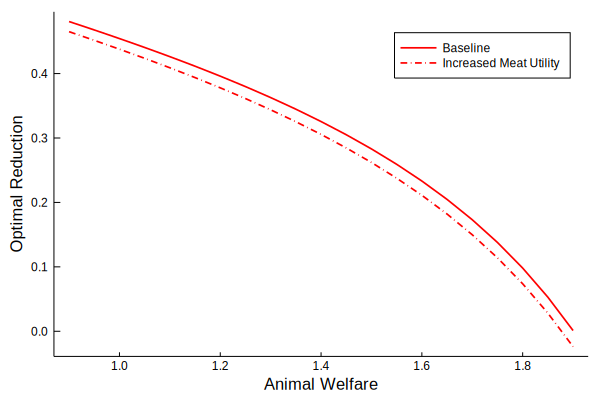

In [138]:
plot(uAs, DiffOpts, linecolor=:red, lw=1.7, linestyle=[:solid :dashdot], label=["Baseline" "Increased Meat Utility"], xlabel="Animal Welfare", ylabel="Optimal Reduction", grid=false)

In [131]:
df=DataFrame(PCGrowth=PCGrowth)

,PCGrowth
,Float64
1,1.0
2,1.0063
3,1.00621
4,1.00613
5,1.00604
6,1.00596
7,1.00604
8,1.00595
9,1.00587


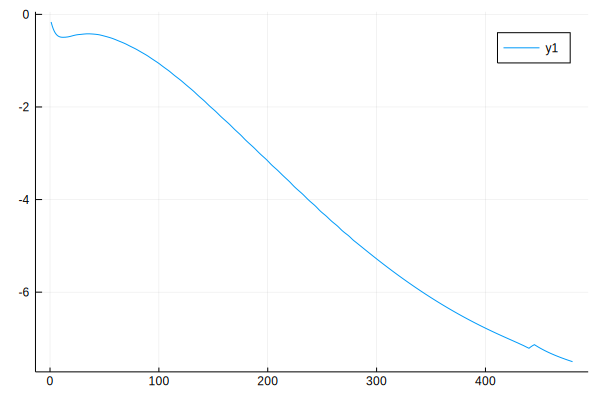

In [48]:
x = [.9, 0,0]	
y = [0,0,0]
SufferingEquiv= 1.9
m 	= create_AnimalWelfareOpt()
	set_param!(m, :farm, :BeefReduc, x[1])
	set_param!(m, :farm, :PoultryReduc, x[2])
	set_param!(m, :farm, :PorkReduc, x[3])
	set_param!(m, :welfare, :CowEquiv, SufferingEquiv)
	set_param!(m, :welfare, :PigEquiv, SufferingEquiv)
	set_param!(m, :welfare, :ChickenEquiv, SufferingEquiv)
    set_param!(m, :welfare, :rho, .001)
    set_param!(m, :farm, :sigmaBeefCo2, 10*65.1)
	set_param!(m, :farm, :sigmaBeefMeth, 10*6.5)
	set_param!(m, :farm, :sigmaBeefN2o, 10*0.22)
	set_param!(m, :farm, :sigmaPoultryCo2, 10*25.6)
	set_param!(m, :farm, :sigmaPoultryMeth, 10*0.02)
	set_param!(m, :farm, :sigmaPoultryN2o, 10*0.03)
	set_param!(m, :farm, :sigmaPorkCo2, 10*25.1)
	set_param!(m, :farm, :sigmaPorkMeth, 10*.7)
	set_param!(m, :farm, :sigmaPorkN2o, 10*.04)	
	run(m)
m2 	= create_AnimalWelfareOpt()
	set_param!(m2, :farm, :BeefReduc, y[1])
	set_param!(m2, :farm, :PoultryReduc, y[2])
	set_param!(m2, :farm, :PorkReduc, y[3])
	set_param!(m2, :welfare, :CowEquiv, SufferingEquiv)
	set_param!(m2, :welfare, :PigEquiv, SufferingEquiv)
	set_param!(m2, :welfare, :ChickenEquiv, SufferingEquiv)
    set_param!(m2, :welfare, :rho, .001)
    set_param!(m2, :farm, :sigmaBeefCo2, 65.1)
	set_param!(m2, :farm, :sigmaBeefMeth, 6.5)
	set_param!(m2, :farm, :sigmaBeefN2o, 0.22)
	set_param!(m2, :farm, :sigmaPoultryCo2, 25.6)
	set_param!(m2, :farm, :sigmaPoultryMeth, 0.02)
	set_param!(m2, :farm, :sigmaPoultryN2o, 0.03)
	set_param!(m2, :farm, :sigmaPorkCo2, 25.1)
	set_param!(m2, :farm, :sigmaPorkMeth, .7)
	set_param!(m2, :farm, :sigmaPorkN2o, .04)	
	run(m2)
TempDiff = plot(m2[:welfare, :CPC][TwentyTwenty+1:end] - m[:welfare, :CPC][TwentyTwenty+1:end])

In [59]:
WelfareDiff_today = m2[:welfare, :MeatPC][TwentyTwenty] #- m2[:welfare, :MeatPC][TwentyTwenty]

1.641417620747038

In [69]:
m1 = (theta_b*(1.4)^epsilon + theta_c*(2.)^epsilon + theta_p*(2.)^epsilon)^(1/epsilon)

1.6781245173550388

In [70]:
m2 = (theta_b*(.9*1.4)^epsilon + theta_c*(2.)^epsilon + theta_p*(2.)^epsilon)^(1/epsilon)

1.595105751387024

In [78]:
PBeef

1303.0

1.052045932312529

In [69]:
veg_outcome()

1×3 Array{Float64,2}:
 1572.0  612.447  99.7007

In [70]:

function create_AnimalWelfareOpt()
m = create_AnimalWelfare()
include(joinpath("components", "AnimalWelfare", "OptimalPolicy", "neteconomy_component.jl"))
include(joinpath("components", "AnimalWelfare", "OptimalPolicy", "farm_component.jl"))
include(joinpath("components", "AnimalWelfare", "OptimalPolicy", "welfare_component.jl"))
replace_comp!(m, farmforpolicy, :farm, reconnect=true)
set_param!(m, :farm, :theta_b, theta_b)
set_param!(m, :farm, :theta_c, theta_c)
set_param!(m, :farm, :theta_p, theta_c)
set_param!(m, :farm, :epsilon, epsilon)
set_param!(m, :farm, :PBeef, PBeef)
set_param!(m, :farm, :PPoultry, PPoultry)
set_param!(m, :farm, :PPork, PPork)
set_param!(m, :farm, :BeefReduc, 0.)
set_param!(m, :farm, :PorkReduc, 0.)
set_param!(m, :farm, :PoultryReduc, 0.)

replace_comp!(m, neteconomyforpolicy, :neteconomy, reconnect=true)
connect_param!(m, :neteconomy, :MeatExp, :farm, :MeatCost)

replace_comp!(m, welfareforpolicy, :welfare, reconnect=true)
set_param!(m, :welfare, :elasmeat, xi)
set_param!(m, :welfare, :alphameat, alpha)

connect_param!(m, :welfare, :Meat, :farm, :Meat)
return m
end

create_AnimalWelfareOpt (generic function with 1 method)

In [71]:
m = create_AnimalWelfareOpt()

23-component Mimi.Model:
  grosseconomy::Main.grosseconomy
  farm::Main.farmforpolicy
  emissions::Main.emissions
  ch4_cycle::MimiFAIR13.ch4_cycle
  n2o_cycle::MimiFAIR13.n2o_cycle
  other_ghg_cycles::MimiFAIR13.other_ghg_cycles
  co2_cycle::MimiFAIR13.co2_cycle
  ch4_rf::MimiFAIR13.ch4_rf
  n2o_rf::MimiFAIR13.n2o_rf
  other_ghg_rf::MimiFAIR13.other_ghg_rf
  co2_rf::MimiFAIR13.co2_rf
  trop_o3_rf::MimiFAIR13.trop_o3_rf
  strat_o3_rf::MimiFAIR13.strat_o3_rf
  aerosol_direct_rf::MimiFAIR13.aerosol_direct_rf
  aerosol_indirect_rf::MimiFAIR13.aerosol_indirect_rf
  bc_snow_rf::MimiFAIR13.bc_snow_rf
  landuse_rf::MimiFAIR13.landuse_rf
  contrails_rf::MimiFAIR13.contrails_rf
  total_rf::MimiFAIR13.total_rf
  temperature::MimiFAIR13.temperature
  damages::Main.damages
  neteconomy::Main.neteconomyforpolicy
  welfare::Main.welfareforpolicy


In [72]:
run(m)

In [54]:
epsilon = 1/(1-rho)
## --- Now need price of each individual product --- ## (right?)
function f!(F, x)
	F[1] 	= (x[1]/x[2])^epsilon * (theta_c/theta_b)^epsilon - (PerCapChicken/PerCapBeef)
	F[2]	= (x[1]/x[3])^epsilon * (theta_p/theta_b)^epsilon - (PerCapPork/PerCapBeef)
	F[3] 	= PerCapBeef*x[1] + PerCapChicken*x[2] + PerCapPork*x[3] - (Ytilde - c)
end

function j!(J, x)
    J[1,1] = epsilon*(x[1]/x[2])^(epsilon-1) * (1/x[2]) * (theta_c/theta_b)^epsilon
    J[1,2] = -epsilon*(x[1]/x[2])^(epsilon-1) *(x[1]/x[2]^2) * (theta_c/theta_b)^epsilon
    J[1,3] = 0
    J[2,1] = epsilon*(x[1]/x[3])^(epsilon-1) * (1/x[3]) * (theta_p/theta_b)^epsilon
    J[2,2] = 0
    J[3,2] = -epsilon*(x[1]/x[3])^(epsilon-1) *(x[1]/x[3]^2) * (theta_p/theta_b)^epsilon
    J[3,1] = PerCapBeef
    J[3,2] = PerCapChicken  
    J[3,3] = PerCapPork      
end

sol = nlsolve(f!, j!, [P; P; P])
#PriceVect = sol.zero
#PBeef 	  = PriceVect[1]
#PPoultry  = PriceVect[2]
#PPork 	  = PriceVect[3]

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [2208.357458473976, 2208.357458473976, 2208.357458473976]
 * Zero: [NaN, NaN, NaN]
 * Inf-norm of residuals: 8300.293431
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 1001
 * Jacobian Calls (df/dx): 1

In [64]:
## Write my own solver
Expenditure = Ytilde - c
expen = 0
Ps = zeros(3)
PBeef = 1000
while expen < Expenditure
    PBeef = pbeef + 1
    PPoultry= pbeef*(theta_c/theta_b)*(PerCapChicken/PerCapBeef)^(-1/epsilon)
    ppork = pbeef*(theta_p/theta_b)*(PerCapPork/PerCapBeef)^(-1/epsilon)
    expen   = PerCapBeef*pbeef + PerCapChicken*pchick + PerCapPork*ppork
    println("Expenditure is $expen")
    Ps = [pbeef pchick ppork]
end

Expenditure is 2308.34661030538
Expenditure is 2310.652650875116
Expenditure is 2312.958691444852
Expenditure is 2315.2647320145875
Expenditure is 2317.570772584323
Expenditure is 2319.8768131540587
Expenditure is 2322.1828537237943
Expenditure is 2324.4888942935295
Expenditure is 2326.7949348632656
Expenditure is 2329.100975433001
Expenditure is 2331.407016002737
Expenditure is 2333.7130565724724
Expenditure is 2336.019097142208
Expenditure is 2338.3251377119436
Expenditure is 2340.6311782816792
Expenditure is 2342.937218851415
Expenditure is 2345.2432594211505
Expenditure is 2347.549299990886
Expenditure is 2349.855340560622
Expenditure is 2352.1613811303578
Expenditure is 2354.4674217000934
Expenditure is 2356.773462269829
Expenditure is 2359.0795028395646
Expenditure is 2361.3855434093
Expenditure is 2363.691583979036
Expenditure is 2365.9976245487715
Expenditure is 2368.303665118507
Expenditure is 2370.609705688243
Expenditure is 2372.9157462579788
Expenditure is 2375.221786827714

Expenditure is 2905.6111178669125
Expenditure is 2907.917158436648
Expenditure is 2910.2231990063838
Expenditure is 2912.5292395761194
Expenditure is 2914.835280145855
Expenditure is 2917.1413207155906
Expenditure is 2919.447361285326
Expenditure is 2921.7534018550623
Expenditure is 2924.059442424798
Expenditure is 2926.365482994533
Expenditure is 2928.671523564269
Expenditure is 2930.9775641340043
Expenditure is 2933.2836047037404
Expenditure is 2935.589645273476
Expenditure is 2937.895685843211
Expenditure is 2940.201726412947
Expenditure is 2942.507766982683
Expenditure is 2944.8138075524184
Expenditure is 2947.119848122154
Expenditure is 2949.4258886918897
Expenditure is 2951.7319292616253
Expenditure is 2954.037969831361
Expenditure is 2956.3440104010965
Expenditure is 2958.650050970832
Expenditure is 2960.956091540568
Expenditure is 2963.2621321103034
Expenditure is 2965.568172680039
Expenditure is 2967.8742132497746
Expenditure is 2970.1802538195107
Expenditure is 2972.486294389

In [65]:
Ps

1×3 Array{Float64,2}:
 1572.0  612.447  99.7007

In [42]:
2208*3

6624

In [36]:
rho = 0
1/(1-rho)

1.0

In [15]:
1/(1-epsilon)

1.8196721311475412

In [17]:
-11.04^epsilon

-2.949890456930711

In [18]:
-11.04^(1-epsilon)

-3.7425118529610923

In [24]:
1/(1-epsilon)

1.8196721311475412

In [22]:
2^3*2

16

In [25]:
1/2^2

0.25

In [59]:
New 	= create_AnimalWelfareOpt()
	set_param!(New, :farm, :BeefReduc, .5)
	set_param!(New, :farm, :PoultryReduc, .5)
	set_param!(New, :farm, :PorkReduc, .5)
run(New)

In [60]:
explore(New)

Electron.Window(Application(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x0000000000000670) open, 0 bytes waiting), Process(`'C:\Users\Kevin\.julia\packages\Electron\aRIgh\src\..\deps\electron\electron.exe' 'C:\Users\Kevin\.julia\packages\Electron\aRIgh\src\main.js' '\\.\pipe\juliaelectron-8032-1' '\\.\pipe\juliaelectron-sysnotify-8032-1' 8VfCWiO990ui4dMKP1RszRGkgvBviciKL9oMTVPMWbB1j4Nhkrk7Jt3LqP4kwp2jcSC84suh87jJRGNIfy5qsR7AMEd32FMoHWbbObV8JsGN1zkO3zGtmkh2nyCFJFIeb1CRJYWk0v2Ftd4FboN8e428nQLE3Z3TWamYyMJmHHs=`, ProcessRunning), [1 window]), 1, true, Channel{Any}(sz_max:128,sz_curr:0))

In [74]:
function f(x)
   y = x[1] + x[2] + x[3]
    return y
end


f (generic function with 2 methods)

In [75]:
f([1 2 3])

6